## Добавление эмбеддингов картинок

В силу большого объема датасета обучение CV модели занимает много времени. В силу чего было решено ограничиться готовыми эмбеддингами. Для этого была взята модель [SigLip2](https://huggingface.co/docs/transformers/model_doc/siglip2) (получение эмбеддингов в ноутбуке calc_image_embeddings.ipynb)

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader

from utils.models import EmbeddingMLP
from utils.preprocess import preprocess_dataset
from utils.training import EmbeddingDataset, train_loop, get_mlp_predictions
from utils.metrics import print_metrics

DEVICE = torch.device("cuda")

In [2]:
train = pd.read_parquet("data/train.parquet")
train_X, train_y = preprocess_dataset(train)
train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, random_state=42, test_size=0.1
)

train_img_inds = train_X.index
val_img_inds = val_X.index
img_embeddings = torch.load("data/train_embeddings_large.pt")

train_img_embeddings = img_embeddings[train_img_inds, :]
val_img_embeddings = img_embeddings[val_img_inds, :]

embedding_dim = img_embeddings.shape[1]

Обучим модель многослойного перцептрона для решения задачи множественной регрессии на эмбеддингах. Будем использовать `L1Loss` - он же MAE.

In [3]:
train_dataset = EmbeddingDataset(train_img_embeddings, train_y)
val_dataset = EmbeddingDataset(val_img_embeddings, val_y)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=True)

In [4]:
test_img_embeddings = torch.load("data/test_embeddings_large.pt")
test_dataset = EmbeddingDataset(test_img_embeddings)

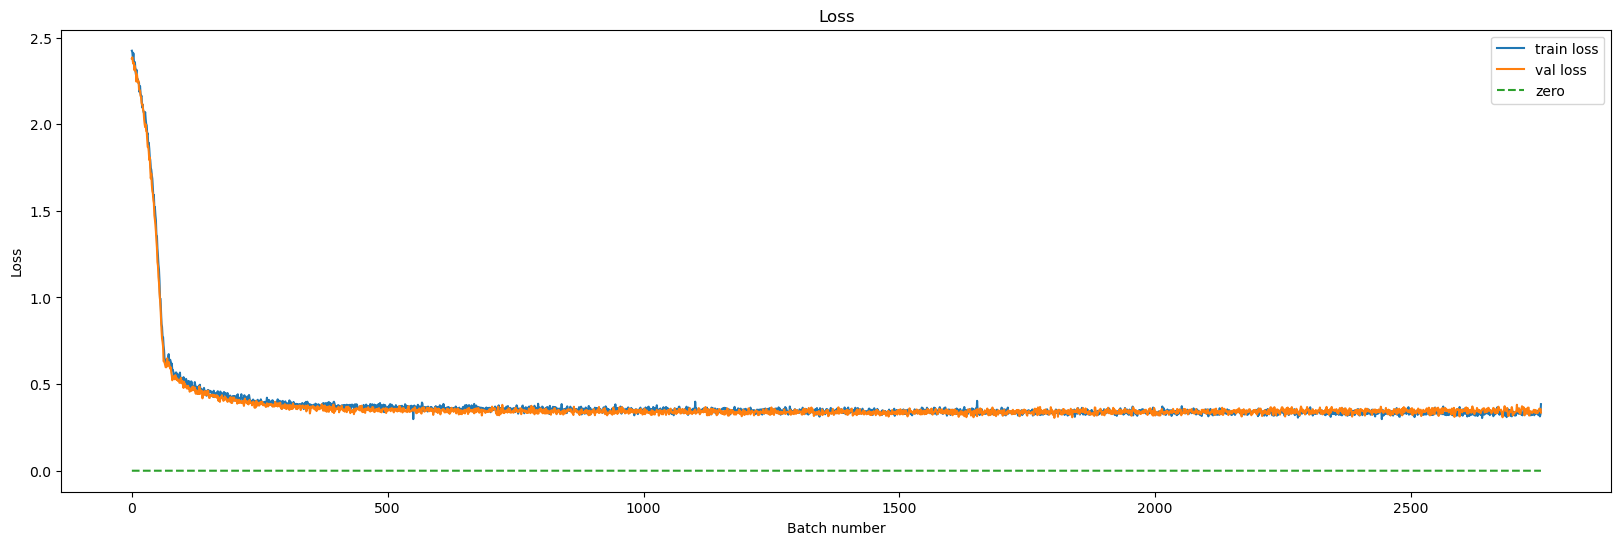

In [ ]:
lr = 0.0001
n_epochs = 5
loss_func = nn.L1Loss()

model = EmbeddingMLP(embedding_dim)
model = model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)

train_loop(
    n_epochs,
    loss_func,
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    DEVICE,
)

In [ ]:
torch.save(model.state_dict(), "models/mlp_siglip_img_embeds_large.pth")

In [9]:
model = EmbeddingMLP(embedding_dim).to(DEVICE)
model.load_state_dict(
    torch.load("models/mlp_siglip_img_embeds_large.pth", weights_only=True)
)

<All keys matched successfully>

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)
mlp_val_preds = get_mlp_predictions(model, val_dataloader, DEVICE)

In [17]:
print_metrics(val_y, mlp_val_preds)

log_real_weight:
	mae=0.2414
	r2=0.5505
	corr=0.7546
log_real_height:
	mae=0.5010
	r2=0.2423
	corr=0.4966
log_real_length:
	mae=0.3066
	r2=0.2197
	corr=0.5221
log_real_width:
	mae=0.3071
	r2=0.2088
	corr=0.4923
Mean MAE: 0.3390


Использование картинок позволяет существенно повысить качество по сравнению с табличными данными. Сохраним полученные предсказания для всех наборов данных

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=False)
mlp_train_preds = get_mlp_predictions(model, train_dataloader, DEVICE)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
mlp_test_preds = get_mlp_predictions(model, test_dataloader, DEVICE)

In [ ]:
np.save(
    "mlp_predictions/train_mlp_siglip_large_predictions.npy", mlp_train_preds
)
np.save("mlp_predictions/val_mlp_siglip_large_predictions.npy", mlp_val_preds)
np.save(
    "mlp_predictions/test_mlp_siglip_large_predictions.npy", mlp_test_preds
)

##  CatBoost на эмбеддингах.

Попробуем заменить MLP на бустинг

In [5]:
from catboost import CatBoostRegressor, Pool

In [19]:
train_pool = Pool(train_img_embeddings.cpu().detach().numpy(), train_y)
val_pool = Pool(val_img_embeddings.cpu().detach().numpy(), val_y)

In [ ]:
cat = CatBoostRegressor(
    loss_function="MultiRMSE",
    od_wait=50,
    n_estimators=5000,
    task_type="GPU",
    use_best_model=True,
)
cat.fit(
    train_pool, eval_set=val_pool, metric_period=10, plot=False, verbose=True
)

In [21]:
cat_preds = cat.predict(val_img_embeddings.cpu().detach().numpy())
print_metrics(val_y, cat_preds)

log_real_weight:
	mae=0.2596
	r2=0.5578
	corr=0.7470
log_real_height:
	mae=0.5140
	r2=0.2576
	corr=0.5076
log_real_length:
	mae=0.2798
	r2=0.2784
	corr=0.5277
log_real_width:
	mae=0.2907
	r2=0.2550
	corr=0.5050
Mean MAE: 0.3360


Бустинг достигает примерно такого же качества. Немного отличаются метрики в зависимости от типа таргета, катбуст где-то хуже, где-то лучше

## Эмбеддинги + табличные данные

Попробуем добавить к картинкам информацию про категории и цену товара

In [6]:
categorical_cols = [
    "item_condition",
    "category_name",
    "subcategory_name",
    "microcat_name",
]

In [ ]:
train_X_w_embeds = pd.concat(
    [
        train_X.reset_index(drop=True),
        pd.DataFrame(
            train_img_embeddings.cpu().detach().numpy(),
            columns=range(embedding_dim),
        ),
    ],
    axis=1,
)

val_X_w_embeds = pd.concat(
    [
        val_X.reset_index(drop=True),
        pd.DataFrame(
            val_img_embeddings.cpu().detach().numpy(),
            columns=range(embedding_dim),
        ),
    ],
    axis=1,
)

In [8]:
train_pool = Pool(train_X_w_embeds, train_y, cat_features=categorical_cols)
val_pool = Pool(val_X_w_embeds, val_y, cat_features=categorical_cols)

In [ ]:
cat = CatBoostRegressor(
    loss_function="MultiRMSE",
    od_wait=50,
    n_estimators=5000,
    task_type="GPU",
    use_best_model=True,
)
cat.fit(
    train_pool, eval_set=val_pool, metric_period=10, plot=False, verbose=True
)

In [10]:
cat_preds = cat.predict(val_X_w_embeds)
print_metrics(val_y, cat_preds)

log_real_weight:
	mae=0.2406
	r2=0.6084
	corr=0.7800
log_real_height:
	mae=0.5049
	r2=0.2799
	corr=0.5291
log_real_length:
	mae=0.2748
	r2=0.2956
	corr=0.5437
log_real_width:
	mae=0.2847
	r2=0.2769
	corr=0.5262
Mean MAE: 0.3262


Использование признаков двух типов позволяет повысить качество

## "Стэкинг": катбуст на табличных данных + предсказаниях MLP

Попробуем взять предсказания MLP, обученного на картиночных эмбеддингах и добавить их к табличным фичам при обучении катбуста

In [ ]:
mlp_train_preds = np.load(
    "mlp_predictions/train_mlp_siglip_large_predicitons.npy"
)
mlp_val_preds = np.load("mlp_predictions/val_mlp_siglip_large_predicitons.npy")

In [12]:
train_X_w_preds = pd.concat(
    [
        train_X.reset_index(drop=True),
        pd.DataFrame(mlp_train_preds, columns=train_y.columns + "_preds"),
    ],
    axis=1,
)

val_X_w_preds = pd.concat(
    [
        val_X.reset_index(drop=True),
        pd.DataFrame(mlp_val_preds, columns=val_y.columns + "_preds"),
    ],
    axis=1,
)

In [13]:
train_pool = Pool(train_X_w_preds, train_y, cat_features=categorical_cols)
val_pool = Pool(val_X_w_preds, val_y, cat_features=categorical_cols)

In [ ]:
cat = CatBoostRegressor(
    loss_function="MultiRMSE",
    od_wait=50,
    n_estimators=5000,
    task_type="GPU",
    use_best_model=True,
)
cat.fit(
    train_pool, eval_set=val_pool, metric_period=10, plot=False, verbose=True
)

In [16]:
cat_preds = cat.predict(val_X_w_preds)
print_metrics(val_y, cat_preds)

log_real_weight:
	mae=0.2328
	r2=0.6196
	corr=0.7872
log_real_height:
	mae=0.5003
	r2=0.2825
	corr=0.5315
log_real_length:
	mae=0.2718
	r2=0.3017
	corr=0.5493
log_real_width:
	mae=0.2831
	r2=0.2825
	corr=0.5315
Mean MAE: 0.3220


Качество получается выше чем при обучении катбуста непосредственно на эмбеддингах + таблице. Таким образом, лучше использовать MLPдля получения предсказаний на основании эмбеддингов картинок, а затем катбуст для их корректировки с добавлением категорий.

In [ ]:
cat.save_model("models/catboost_imgpreds_table")